## This notebook presents the reproducible procedure that we followed in comparing the performance of Hybrid Quantum-Classical Neural Networks and Classical Convolutional Neural Networks on the G1020 dataset. The G1020 dataset is a glaucoma-focused dataset with 1020 fundus images. The dataset was produced in Germany and is labeled with binary classification (Non-Glaucoma and Glaucoma).

### Installing and Importing Dependencies

In [1]:
!pip install pennylane

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 48.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.8/930.8 kB 65.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 98.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 95.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 118.5 MB/s eta 0:00:00


In [2]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import os
from google.colab import drive
import cv2
from sklearn.model_selection import train_test_split
import pandas as pd
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, Sampler
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, transforms
from PIL import Image
import time
import os
import copy
from torch.optim.lr_scheduler import CosineAnnealingLR
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score, confusion_matrix, roc_curve,
    precision_recall_curve, auc
)
from sklearn.preprocessing import label_binarize
import random


os.environ["OMP_NUM_THREADS"] = "1"

In [3]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
MODEL_SAVE_PATH = "/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/Resnet-18-G1020_models/"

### General Training, Validation, Testing Functions

In [5]:
import torchvision
from torchvision import datasets, transforms

In [6]:
def train_model(model, train_loader, optimizer, criterion):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_probs = []

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        probs = torch.softmax(outputs, dim=1)
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.detach().cpu().numpy())



    avg_train_loss = train_loss / len(train_loader.dataset)
    accuracy = correct / total * 100

    aurocs = []
    for i in range(probs.shape[1]):
        try:
            auroc = roc_auc_score([1 if label == i else 0 for label in all_labels], [prob[i] for prob in all_probs])
            aurocs.append(auroc)
        except ValueError:
            aurocs.append(0)

    avg_auroc = sum(aurocs) / len(aurocs)

    return avg_train_loss, accuracy, avg_auroc

In [7]:
def validate_model(model, valid_loader, criterion):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    all_labels = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            probs = torch.softmax(outputs, dim=1)
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.detach().cpu().numpy())

    avg_val_loss = val_loss / len(valid_loader.dataset)
    accuracy = correct / total * 100
    aurocs = []
    for i in range(probs.shape[1]):
        try:
            auroc = roc_auc_score([1 if label == i else 0 for label in all_labels], [prob[i] for prob in all_probs])
            aurocs.append(auroc)
        except ValueError:
            aurocs.append(0)

    avg_auroc = sum(aurocs) / len(aurocs)

    return avg_val_loss, accuracy, avg_auroc

In [8]:
import pickle

def train_validate_model(n_epochs, model, model_name, train_loader, valid_loader, seed):

  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

  def adjust_learning_rate(optimizer, epoch, lr_warmup_epochs, lr_max):
        if epoch < lr_warmup_epochs:
            lr = lr_max * (epoch + 1) / lr_warmup_epochs
        else:
            lr = lr_max
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr

  scheduler = CosineAnnealingLR(optimizer, T_max=n_epochs - 10, eta_min=1e-6)

  best_val_loss = float('inf')
  best_model_weights = model.state_dict()
  epochs_without_improvement = 0
  early_stopping_patience = 10

  train_losses = []
  train_accuracies = []
  val_losses = []
  val_accuracies = []
  train_aucs = []
  val_aucs = []

  lr_max = 5e-4
  lr_warmup_epochs = 10

  for epoch in range(n_epochs):
      print(f'Epoch [{epoch+1}/{n_epochs}]')

      adjust_learning_rate(optimizer, epoch, lr_warmup_epochs, lr_max)

      train_loss, train_accuracy, train_auroc = train_model(model, train_loader, optimizer, criterion)
      val_loss, val_accuracy, val_auroc = validate_model(model, valid_loader, criterion)


      print(f'Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%, Training AUROC: {train_auroc:.4f}')
      print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%, Validation AUROC: {val_auroc:.4f}')
      train_losses.append(train_loss)
      train_accuracies.append(train_accuracy)
      train_aucs.append(train_auroc)
      val_losses.append(val_loss)
      val_accuracies.append(val_accuracy)
      val_aucs.append(val_auroc)

      if epoch >= lr_warmup_epochs:
            scheduler.step()

      if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_weights = model.state_dict()
            epochs_without_improvement = 0  # Reset counter

      else:
            epochs_without_improvement += 1

      if epochs_without_improvement >= early_stopping_patience:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            break

  model.load_state_dict(best_model_weights)
  torch.save(model, os.path.join(MODEL_SAVE_PATH, f'{model_name}_{seed}.pth'))

  metrics = {
        "train_losses": train_losses,
        "train_accuracies": train_accuracies,
        "train_aucs": train_aucs,
        "val_losses": val_losses,
        "val_accuracies": val_accuracies,
        "val_aucs": val_aucs
    }

  with open(os.path.join(MODEL_SAVE_PATH, f'{model_name}_{seed}_metrics.pkl'), 'wb') as f:
        pickle.dump(metrics, f)


  return model, train_losses, train_accuracies, val_losses, val_accuracies, train_aucs, val_aucs

In [9]:
import math
import matplotlib.pyplot as plt

def plot(quantum_loss, normal_loss, quantum_acc, normal_acc, quantum_auc, normal_auc):
    plt.style.use("default")

    loss_min = math.floor(min(min(quantum_loss), min(normal_loss)) * 10) / 10
    loss_max = math.ceil(max(max(quantum_loss), max(normal_loss)) * 10) / 10

    acc_min = math.floor(min(min(quantum_acc), min(normal_acc)) * 10) / 10
    acc_max = math.ceil(max(max(quantum_acc), max(normal_acc)) * 10) / 10

    auc_min = math.floor(min(min(quantum_auc), min(normal_auc)) * 10) / 10
    auc_max = math.ceil(max(max(quantum_auc), max(normal_auc)) * 10) / 10

    plt.figure(figsize=(6, 3))
    plt.plot(quantum_loss, label="With quantum layer")
    plt.plot(normal_loss, label="Without quantum layer")
    plt.ylabel("Loss")
    plt.ylim([loss_min, loss_max])
    plt.xlabel("Epoch")
    plt.legend()
    plt.title("Loss vs. Epoch")
    plt.show()

    plt.figure(figsize=(6, 3))
    plt.plot(quantum_acc, label="With quantum layer")
    plt.plot(normal_acc, label="Without quantum layer")
    plt.ylabel("Accuracy")
    plt.ylim([acc_min, acc_max])
    plt.xlabel("Epoch")
    plt.legend()
    plt.title("Accuracy vs. Epoch")
    plt.show()

    plt.figure(figsize=(6, 3))
    plt.plot(quantum_auc, label="With quantum layer")
    plt.plot(normal_auc, label="Without quantum layer")
    plt.ylabel("ROCAUC")
    plt.ylim([auc_min, auc_max])
    plt.xlabel("Epoch")
    plt.legend()
    plt.title("ROCAUC vs. Epoch")
    plt.show()


In [10]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,
)
from sklearn.preprocessing import label_binarize
from itertools import cycle


def test(model_hybrid, model_normal, test_loader, num_classes):
    model_hybrid.eval()
    model_normal.eval()

    all_labels = []
    all_preds_hybrid = []
    all_preds_normal = []
    all_probs_hybrid = []
    all_probs_normal = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)


            outputs_hybrid = model_hybrid(images)
            _, preds_hybrid = torch.max(outputs_hybrid, 1)
            probs_hybrid = torch.softmax(outputs_hybrid, dim=1)
            # Normal model predictions
            outputs_normal = model_normal(images)
            _, preds_normal = torch.max(outputs_normal, 1)
            probs_normal = torch.softmax(outputs_normal, dim=1)

            all_labels.extend(labels.cpu().numpy())
            all_preds_hybrid.extend(preds_hybrid.cpu().numpy())
            all_preds_normal.extend(preds_normal.cpu().numpy())
            all_probs_hybrid.extend(probs_hybrid.cpu().numpy())
            all_probs_normal.extend(probs_normal.cpu().numpy())

    all_labels = np.array(all_labels)
    all_preds_hybrid = np.array(all_preds_hybrid)
    all_preds_normal = np.array(all_preds_normal)
    all_probs_hybrid = np.array(all_probs_hybrid)
    all_probs_normal = np.array(all_probs_normal)


    accuracy_hybrid = accuracy_score(all_labels, all_preds_hybrid)
    accuracy_normal = accuracy_score(all_labels, all_preds_normal)


    f1_hybrid = f1_score(all_labels, all_preds_hybrid, average='weighted')
    f1_normal = f1_score(all_labels, all_preds_normal, average='weighted')


    if num_classes == 2:
        precision_hybrid = precision_score(all_labels, all_preds_hybrid, pos_label=1)
        recall_hybrid = recall_score(all_labels, all_preds_hybrid, pos_label=1)
        precision_normal = precision_score(all_labels, all_preds_normal, pos_label=1)
        recall_normal = recall_score(all_labels, all_preds_normal, pos_label=1)
    else:
        precision_hybrid = precision_score(all_labels, all_preds_hybrid, average='weighted')
        recall_hybrid = recall_score(all_labels, all_preds_hybrid, average='weighted')
        precision_normal = precision_score(all_labels, all_preds_normal, average='weighted')
        recall_normal = recall_score(all_labels, all_preds_normal, average='weighted')


    hybrid_aucs = []
    normal_aucs = []

    if num_classes == 2:

        all_probs_hybrid_class1 = all_probs_hybrid[:, 1]
        all_probs_normal_class1 = all_probs_normal[:, 1]

        auc_hybrid = roc_auc_score(all_labels, all_probs_hybrid_class1)
        auc_normal = roc_auc_score(all_labels, all_probs_normal_class1)


        fpr_hybrid, tpr_hybrid, _ = roc_curve(all_labels, all_probs_hybrid_class1)
        plt.figure(figsize=(10, 6))
        plt.plot(fpr_hybrid, tpr_hybrid, label=f'Hybrid Model AUROC = {auc_hybrid:.4f}')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.title('ROC Curve - Hybrid Model')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend(loc='lower right')
        plt.show()

        # Plot ROC curve for the Normal Model
        fpr_normal, tpr_normal, _ = roc_curve(all_labels, all_probs_normal_class1)
        plt.figure(figsize=(10, 6))
        plt.plot(fpr_normal, tpr_normal, label=f'Normal Model AUROC = {auc_normal:.4f}')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.title('ROC Curve - Normal Model')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend(loc='lower right')
        plt.show()



        print("\nHybrid Model Metrics:")
        print(f'Accuracy: {accuracy_hybrid:.4f}')
        print(f'F1 Score: {f1_hybrid:.4f}')
        print(f'Precision: {precision_hybrid:.4f}')
        print(f'Recall: {recall_hybrid:.4f}')
        print(f'AUROC: {auc_hybrid}')

        print("\nNormal Model Metrics:")
        print(f'Accuracy: {accuracy_normal:.4f}')
        print(f'F1 Score: {f1_normal:.4f}')
        print(f'Precision: {precision_normal:.4f}')
        print(f'Recall: {recall_normal:.4f}')
        print(f'AUROC: {auc_normal} \n')

        cm_hybrid = confusion_matrix(all_labels, all_preds_hybrid)


        plt.figure(figsize=(6, 5))
        sns.heatmap(cm_hybrid, annot=True, fmt='d', cmap='Blues', cbar=False)
        plt.title(f'Confusion Matrix: Hybrid Model (Avg AUC = {auc_hybrid})')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()

        cm_normal = confusion_matrix(all_labels, all_preds_normal)

        plt.figure(figsize=(6, 5))
        sns.heatmap(cm_normal, annot=True, fmt='d', cmap='Blues', cbar=False)
        plt.title(f'Confusion Matrix: Classical Model (Avg AUC = {auc_normal})')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()


    else:  # Multi-class Classification

        all_labels_binarized = label_binarize(all_labels, classes=np.arange(num_classes))

        # Define a color cycle for plotting
        colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red'])
        # Plot ROC curves for the Hybrid Model
        plt.figure(figsize=(10, 8))
        for i, color in zip(range(num_classes), colors):
            fpr, tpr, _ = roc_curve(all_labels_binarized[:, i], all_probs_hybrid[:, i])
            roc_auc = auc(fpr, tpr)
            hybrid_aucs.append(roc_auc)
            plt.plot(fpr, tpr, color=color, lw=2,
                    label=f'Class {i} (AUC = {roc_auc:.2f})')


        plt.plot([0, 1], [0, 1], 'k--', lw=2)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curves - Hybrid Model')
        plt.legend(loc='lower right')
        plt.show()

        # Plot ROC curves for the Normal Model
        plt.figure(figsize=(10, 8))
        for i, color in zip(range(num_classes), colors):
            fpr, tpr, _ = roc_curve(all_labels_binarized[:, i], all_probs_normal[:, i])
            roc_auc = auc(fpr, tpr)
            normal_aucs.append(roc_auc)
            plt.plot(fpr, tpr, color=color, lw=2,
                    label=f'Class {i} (AUC = {roc_auc:.2f})')


        plt.plot([0, 1], [0, 1], 'k--', lw=2)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curves - Normal Model')
        plt.legend(loc='lower right')
        plt.show()



        normal_auc = f"{sum(normal_aucs) / len(normal_aucs):.4f}"
        hybrid_auc = f"{sum(hybrid_aucs) / len(hybrid_aucs):.4f}"

        print("\nHybrid Model Metrics:")
        print(f'Accuracy: {accuracy_hybrid:.4f}')
        print(f'F1 Score: {f1_hybrid:.4f}')
        print(f'Precision: {precision_hybrid:.4f}')
        print(f'Recall: {recall_hybrid:.4f}')
        print(f'AUROC: {hybrid_auc}')

        print("\nNormal Model Metrics:")
        print(f'Accuracy: {accuracy_normal:.4f}')
        print(f'F1 Score: {f1_normal:.4f}')
        print(f'Precision: {precision_normal:.4f}')
        print(f'Recall: {recall_normal:.4f}')
        print(f'AUROC: {normal_auc} \n')

        cm_hybrid = confusion_matrix(all_labels, all_preds_hybrid)


        plt.figure(figsize=(6, 5))
        sns.heatmap(cm_hybrid, annot=True, fmt='d', cmap='Blues', cbar=False)
        plt.title(f'Confusion Matrix: Hybrid Model (Avg AUC = {hybrid_auc})')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()

        cm_normal = confusion_matrix(all_labels, all_preds_normal)

        plt.figure(figsize=(6, 5))
        sns.heatmap(cm_normal, annot=True, fmt='d', cmap='Blues', cbar=False)
        plt.title(f'Confusion Matrix: Classical Model (Avg AUC = {normal_auc})')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()

In [11]:
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True

In [12]:
def load_data(batch_size, dataset):

  train_transform = transforms.Compose([
      transforms.Resize((224, 224)),
      transforms.RandomHorizontalFlip(),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
  ])

  valid_test_transform = transforms.Compose([
      transforms.Resize((224, 224)),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
  ])


  if dataset == 'APTOS':
    data_dir = "/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/APTOS2019/"

  elif dataset == "IDRID":
    data_dir = "/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/IDRID_images/"

  elif dataset == "Messidor":
    data_dir = "/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/MESSIDOR2/"

  elif dataset == "GlaucomaFundus":
    data_dir = "/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/Glaucoma_fundus/"

  elif dataset == "PAPILA":
    data_dir = "/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/PAPILA/"

  elif dataset == 'G1020':
    data_dir = "/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/G1020/"


  train_dataset = datasets.ImageFolder(root=data_dir + 'train', transform=train_transform)
  val_dataset = datasets.ImageFolder(root=data_dir + 'val', transform=valid_test_transform)
  test_dataset = datasets.ImageFolder(root=data_dir + 'test', transform=valid_test_transform)

  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=False)
  valid_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=False)
  test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

  return train_loader, valid_loader, test_loader

### Classical Resnet-18 Construction

In [13]:
class NormalModel(nn.Module):
  def __init__(self, freeze, num_classes, device='cuda'):
        super(NormalModel, self).__init__()

        weights = torchvision.models.ResNet18_Weights.IMAGENET1K_V1
        self.model = torchvision.models.resnet18(weights=weights)

        if freeze:
          for param in self.model.parameters():
              param.requires_grad = False

        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)
        self.model = self.model.to(device)

  def forward(self, x):
        return self.model(x)

### Hybrid Quantum-Classical Resnet-18 Construction

In [14]:
n_qubits = 4                # Number of qubits
step = 0.0004               # Learning rate
batch_size = 4              # Number of samples for each training step
q_delta = 0.01              # Initial spread of random quantum weights
start_time = time.time()    # Start of the computation timer

In [15]:
def H_layer(nqubits):
    """Layer of single-qubit Hadamard gates.
    """
    for idx in range(nqubits):
        qml.Hadamard(wires=idx)


def RY_layer(w):
    """Layer of parametrized qubit rotations around the y axis.
    """
    for idx, element in enumerate(w):
        qml.RY(element, wires=idx)


def entangling_layer(nqubits):
    """Layer of CNOTs followed by another shifted layer of CNOT.
    """
    for i in range(0, nqubits - 1, 2):
        qml.CNOT(wires=[i, i + 1])
    for i in range(1, nqubits - 1, 2):
        qml.CNOT(wires=[i, i + 1])

In [16]:
dev = qml.device("default.qubit", wires=n_qubits)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [17]:
@qml.qnode(dev)
def quantum_net(q_input_features, q_weights_flat):
    """
    The variational quantum circuit.
    """

    # Reshape weights
    q_weights = q_weights_flat.reshape(q_depth, n_qubits)

    # Start from state |+> , unbiased w.r.t. |0> and |1>
    H_layer(n_qubits)

    # Embed features in the quantum node
    RY_layer(q_input_features)

    # Sequence of trainable variational layers
    for k in range(q_depth):
        entangling_layer(n_qubits)
        RY_layer(q_weights[k])

    # Expectation values in the Z basis
    exp_vals = [qml.expval(qml.PauliZ(position)) for position in range(n_qubits)]
    return tuple(exp_vals)

In [18]:
class DressedQuantumNet(nn.Module):

    def __init__(self, q_depth, num_classes):

        super().__init__()
        self.pre_net = nn.Linear(512, n_qubits)
        self.q_params = nn.Parameter(q_delta * torch.randn(q_depth * n_qubits))
        self.post_net = nn.Linear(n_qubits, num_classes)

    def forward(self, input_features):


        pre_out = self.pre_net(input_features)
        q_in = torch.tanh(pre_out) * np.pi / 2.0

        # Apply the quantum circuit to each element of the batch and append to q_out
        q_out = torch.Tensor(0, n_qubits)
        q_out = q_out.to(device)
        for elem in q_in:
            q_out_elem = torch.hstack(quantum_net(elem, self.q_params)).float().unsqueeze(0)
            q_out = torch.cat((q_out, q_out_elem))

        # return the two-dimensional prediction from the postprocessing layer
        return self.post_net(q_out)

In [19]:
class QuantumHybridModel(nn.Module):
  def __init__(self, q_depth, freeze, num_classes, device='cuda'):
        super(QuantumHybridModel, self).__init__()

        weights = torchvision.models.ResNet18_Weights.IMAGENET1K_V1
        self.model = torchvision.models.resnet18(weights=weights)

        if freeze:
          for param in self.model.parameters():
              param.requires_grad = False

        self.model.fc = DressedQuantumNet(q_depth, num_classes)

        self.model = self.model.to(device)

  def forward(self, x):
        return self.model(x)

# Experiments

In [20]:
n_epochs = 100
num_classes = 2
batch_size = 32
dataset = "G1020"
model_name_hybrid = 'quantum_hybrid_model'
model_name_normal = 'normal_model'
q_depth = 4

## Seed Experiment 1

In [26]:
seed = random.randint(1, 100)
print(f"Experiment with Seed {seed}:")
set_seed(seed)
train_loader, valid_loader, test_loader = load_data(batch_size=batch_size, dataset=dataset)
model = NormalModel(freeze=True, num_classes=2)
hybrid_model = QuantumHybridModel(q_depth=4, freeze=True, num_classes=2)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_name_hybrid = 'quantum_hybrid_model'
model_name_normal = 'normal_model'

Experiment with Seed 10:


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 71.4MB/s]


In [27]:
model_normal, normal_train_losses, normal_train_accs, normal_val_losses, normal_val_accs, normal_train_aucs, normal_val_aucs = train_validate_model(
    n_epochs=n_epochs,
    model=model,
    model_name=model_name_normal,
    train_loader=train_loader,
    valid_loader=valid_loader,
    seed=seed
)

Epoch [1/100]
Training Loss: 0.6522, Training Accuracy: 68.98%, Training AUROC: 0.4502
Validation Loss: 0.5748, Validation Accuracy: 73.94%, Validation AUROC: 0.5606
Epoch [2/100]
Training Loss: 0.6505, Training Accuracy: 68.43%, Training AUROC: 0.4532
Validation Loss: 0.5727, Validation Accuracy: 75.15%, Validation AUROC: 0.5059
Epoch [3/100]
Training Loss: 0.6476, Training Accuracy: 69.16%, Training AUROC: 0.4502
Validation Loss: 0.5730, Validation Accuracy: 75.76%, Validation AUROC: 0.4886
Epoch [4/100]
Training Loss: 0.6515, Training Accuracy: 69.89%, Training AUROC: 0.4766
Validation Loss: 0.5828, Validation Accuracy: 73.94%, Validation AUROC: 0.4969
Epoch [5/100]
Training Loss: 0.6366, Training Accuracy: 68.25%, Training AUROC: 0.4840
Validation Loss: 0.5832, Validation Accuracy: 73.94%, Validation AUROC: 0.4807
Epoch [6/100]
Training Loss: 0.6366, Training Accuracy: 68.25%, Training AUROC: 0.4779
Validation Loss: 0.5711, Validation Accuracy: 75.76%, Validation AUROC: 0.4737
Epoc

In [28]:
model_hybrid, hybrid_train_losses, hybrid_train_accs, hybrid_val_losses, hybrid_val_accs, hybrid_train_aucs, hybrid_val_aucs = train_validate_model(
    n_epochs=n_epochs,
    model=hybrid_model,
    model_name=model_name_hybrid,
    train_loader=train_loader,
    valid_loader=valid_loader,
    seed=seed
)

Epoch [1/100]
Training Loss: 0.6799, Training Accuracy: 60.22%, Training AUROC: 0.4606
Validation Loss: 0.6108, Validation Accuracy: 74.55%, Validation AUROC: 0.4526
Epoch [2/100]
Training Loss: 0.6281, Training Accuracy: 69.16%, Training AUROC: 0.5011
Validation Loss: 0.5824, Validation Accuracy: 76.36%, Validation AUROC: 0.4265
Epoch [3/100]
Training Loss: 0.6152, Training Accuracy: 70.07%, Training AUROC: 0.5032
Validation Loss: 0.5689, Validation Accuracy: 76.36%, Validation AUROC: 0.4550
Epoch [4/100]
Training Loss: 0.6132, Training Accuracy: 70.26%, Training AUROC: 0.4929
Validation Loss: 0.5726, Validation Accuracy: 76.36%, Validation AUROC: 0.4392
Epoch [5/100]
Training Loss: 0.6082, Training Accuracy: 70.26%, Training AUROC: 0.5270
Validation Loss: 0.5678, Validation Accuracy: 76.36%, Validation AUROC: 0.4420
Epoch [6/100]
Training Loss: 0.6085, Training Accuracy: 70.26%, Training AUROC: 0.5256
Validation Loss: 0.5609, Validation Accuracy: 76.36%, Validation AUROC: 0.4636
Epoc

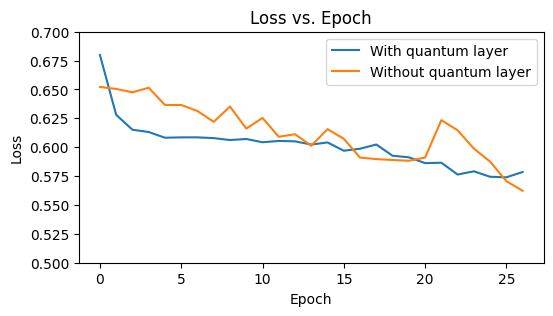

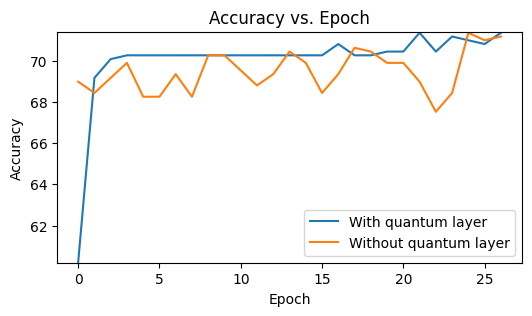

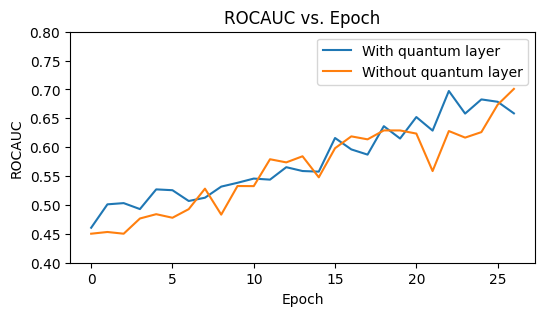

In [29]:
plot(hybrid_train_losses, normal_train_losses, hybrid_train_accs, normal_train_accs, hybrid_train_aucs, normal_train_aucs)

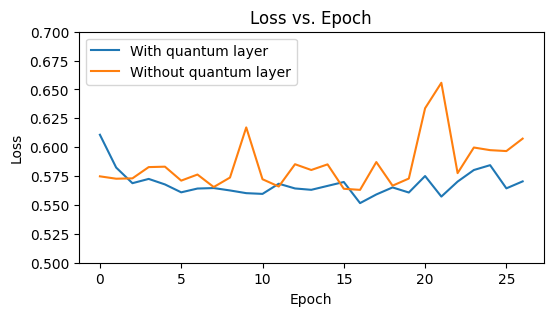

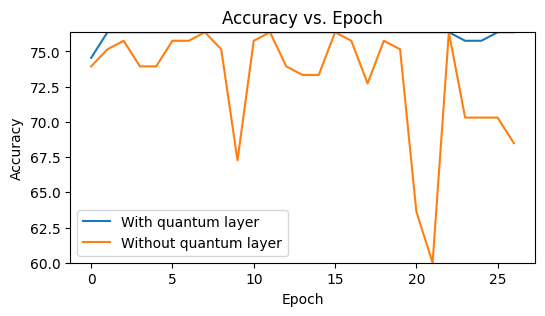

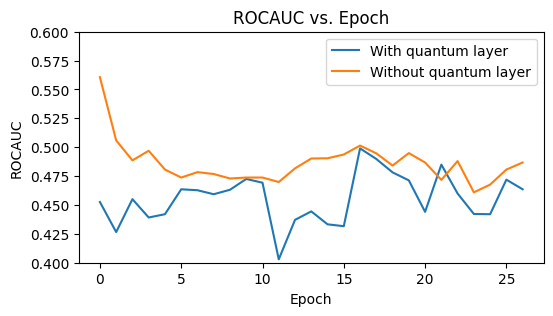

In [30]:
plot(hybrid_val_losses, normal_val_losses, hybrid_val_accs, normal_val_accs, hybrid_val_aucs, normal_val_aucs)

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


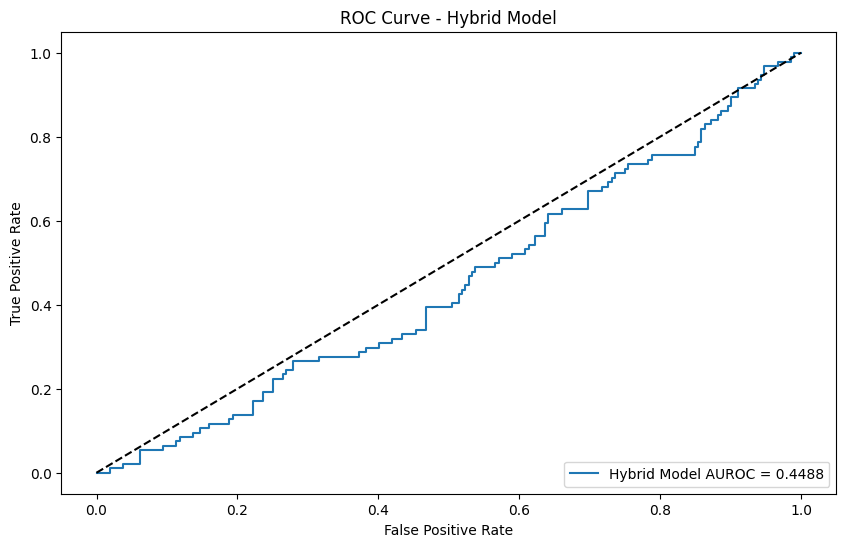

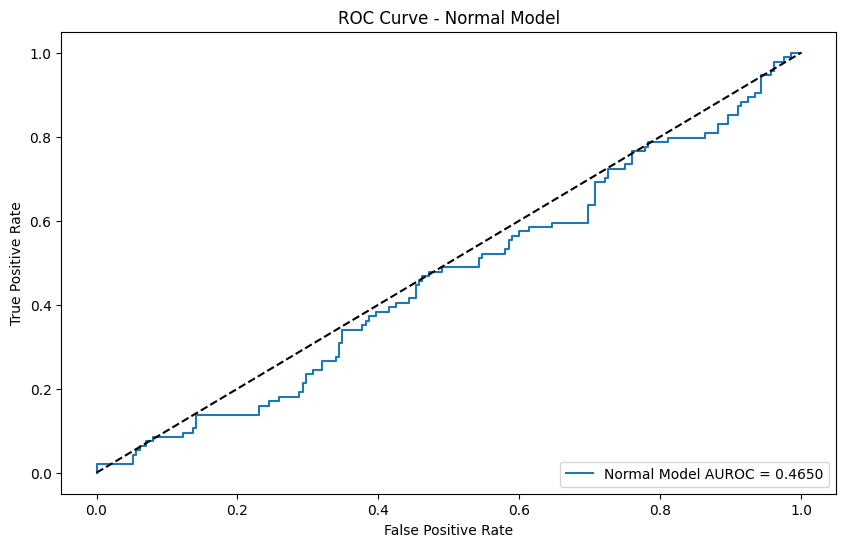


Hybrid Model Metrics:
Accuracy: 0.6928
F1 Score: 0.5671
Precision: 0.0000
Recall: 0.0000
AUROC: 0.4487655560016058

Normal Model Metrics:
Accuracy: 0.6340
F1 Score: 0.5870
Precision: 0.2955
Recall: 0.1383
AUROC: 0.4649739060618226 



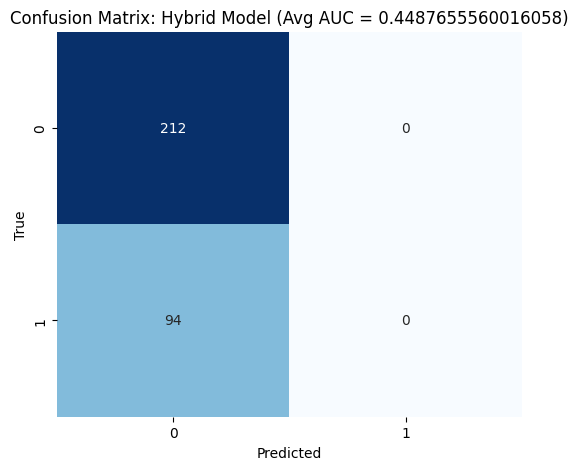

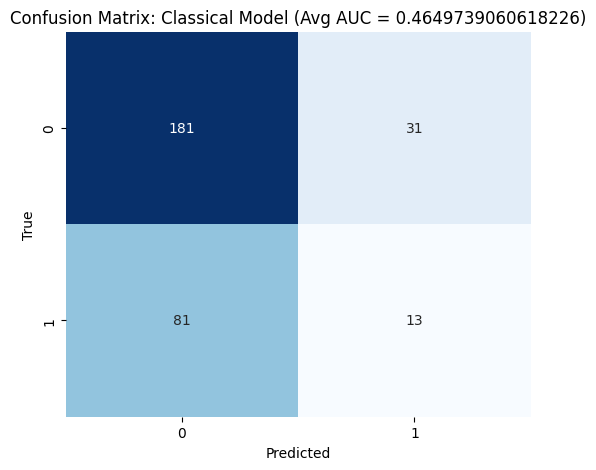

In [31]:
test(model_hybrid, model_normal, test_loader, num_classes=num_classes)

## Seed Experiment 2

In [32]:
seed = random.randint(1, 100)
print(f"Experiment with Seed {seed}:")
set_seed(seed)
train_loader, valid_loader, test_loader = load_data(batch_size=batch_size, dataset=dataset)
model = NormalModel(freeze=True, num_classes=2)
hybrid_model = QuantumHybridModel(q_depth=4, freeze=True, num_classes=2)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_name_hybrid = 'quantum_hybrid_model'
model_name_normal = 'normal_model'

Experiment with Seed 74:


In [33]:
model_normal, normal_train_losses, normal_train_accs, normal_val_losses, normal_val_accs, normal_train_aucs, normal_val_aucs = train_validate_model(
    n_epochs=n_epochs,
    model=model,
    model_name=model_name_normal,
    train_loader=train_loader,
    valid_loader=valid_loader,
    seed=seed
)

Epoch [1/100]
Training Loss: 0.7202, Training Accuracy: 52.19%, Training AUROC: 0.4980
Validation Loss: 0.6358, Validation Accuracy: 66.06%, Validation AUROC: 0.5067
Epoch [2/100]
Training Loss: 0.6372, Training Accuracy: 66.79%, Training AUROC: 0.5166
Validation Loss: 0.5864, Validation Accuracy: 75.15%, Validation AUROC: 0.4794
Epoch [3/100]
Training Loss: 0.6268, Training Accuracy: 69.89%, Training AUROC: 0.5481
Validation Loss: 0.5896, Validation Accuracy: 73.94%, Validation AUROC: 0.4890
Epoch [4/100]
Training Loss: 0.6253, Training Accuracy: 69.16%, Training AUROC: 0.5291
Validation Loss: 0.6035, Validation Accuracy: 73.33%, Validation AUROC: 0.4782
Epoch [5/100]
Training Loss: 0.6414, Training Accuracy: 66.97%, Training AUROC: 0.4949
Validation Loss: 0.5893, Validation Accuracy: 73.94%, Validation AUROC: 0.4807
Epoch [6/100]
Training Loss: 0.6285, Training Accuracy: 68.07%, Training AUROC: 0.5201
Validation Loss: 0.5822, Validation Accuracy: 74.55%, Validation AUROC: 0.4876
Epoc

In [34]:
model_hybrid, hybrid_train_losses, hybrid_train_accs, hybrid_val_losses, hybrid_val_accs, hybrid_train_aucs, hybrid_val_aucs = train_validate_model(
    n_epochs=n_epochs,
    model=hybrid_model,
    model_name=model_name_hybrid,
    train_loader=train_loader,
    valid_loader=valid_loader,
    seed=seed
)

Epoch [1/100]
Training Loss: 0.6717, Training Accuracy: 58.76%, Training AUROC: 0.5183
Validation Loss: 0.5929, Validation Accuracy: 74.55%, Validation AUROC: 0.5210
Epoch [2/100]
Training Loss: 0.6138, Training Accuracy: 70.07%, Training AUROC: 0.5240
Validation Loss: 0.5600, Validation Accuracy: 75.76%, Validation AUROC: 0.4957
Epoch [3/100]
Training Loss: 0.6189, Training Accuracy: 70.26%, Training AUROC: 0.4702
Validation Loss: 0.5553, Validation Accuracy: 75.76%, Validation AUROC: 0.4754
Epoch [4/100]
Training Loss: 0.6147, Training Accuracy: 70.26%, Training AUROC: 0.4897
Validation Loss: 0.5614, Validation Accuracy: 75.76%, Validation AUROC: 0.4668
Epoch [5/100]
Training Loss: 0.6095, Training Accuracy: 70.26%, Training AUROC: 0.5281
Validation Loss: 0.5588, Validation Accuracy: 76.36%, Validation AUROC: 0.4495
Epoch [6/100]
Training Loss: 0.6110, Training Accuracy: 70.26%, Training AUROC: 0.5143
Validation Loss: 0.5620, Validation Accuracy: 76.36%, Validation AUROC: 0.4455
Epoc

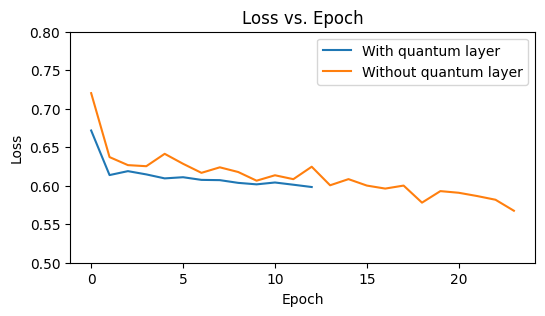

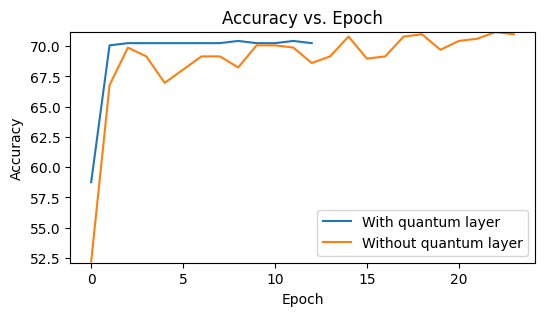

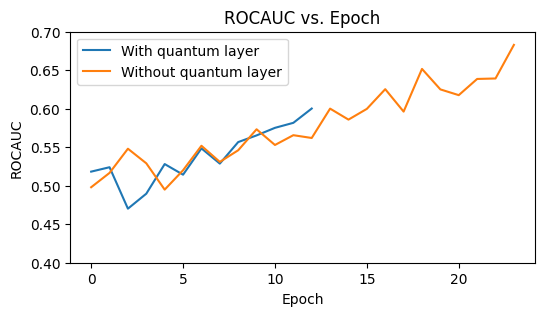

In [35]:
plot(hybrid_train_losses, normal_train_losses, hybrid_train_accs, normal_train_accs, hybrid_train_aucs, normal_train_aucs)

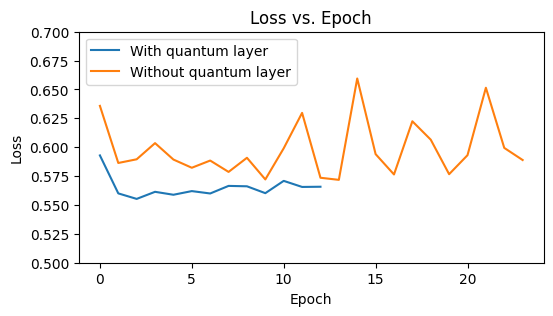

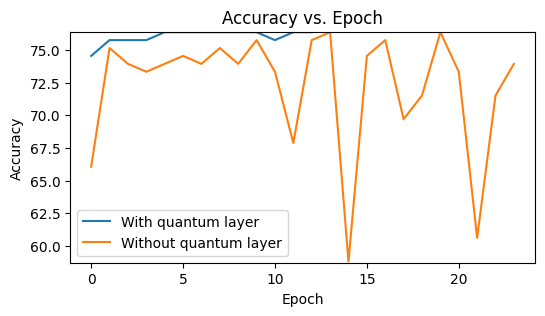

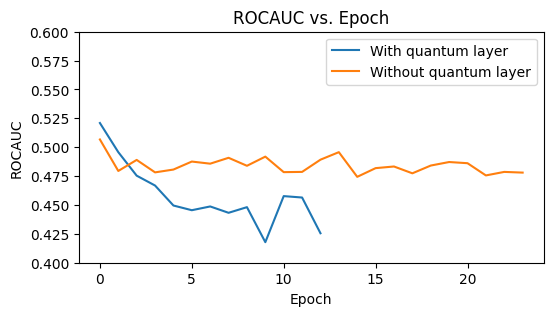

In [36]:
plot(hybrid_val_losses, normal_val_losses, hybrid_val_accs, normal_val_accs, hybrid_val_aucs, normal_val_aucs)

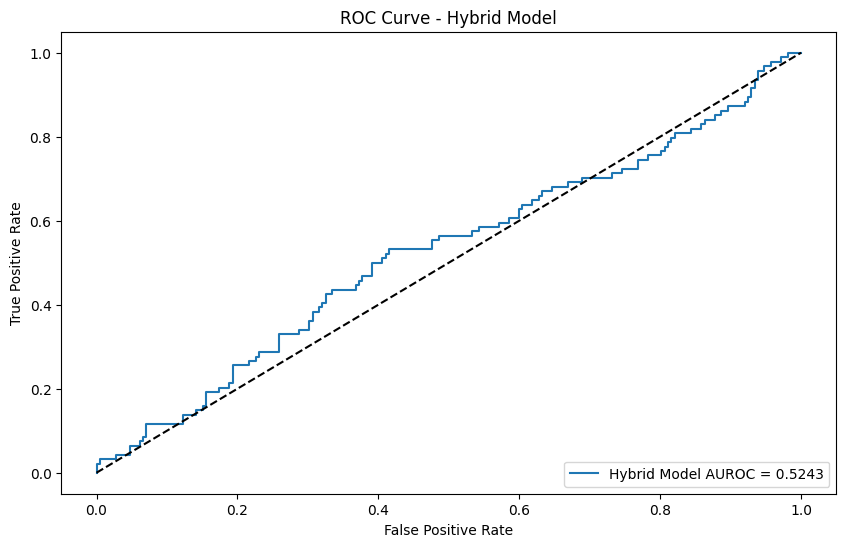

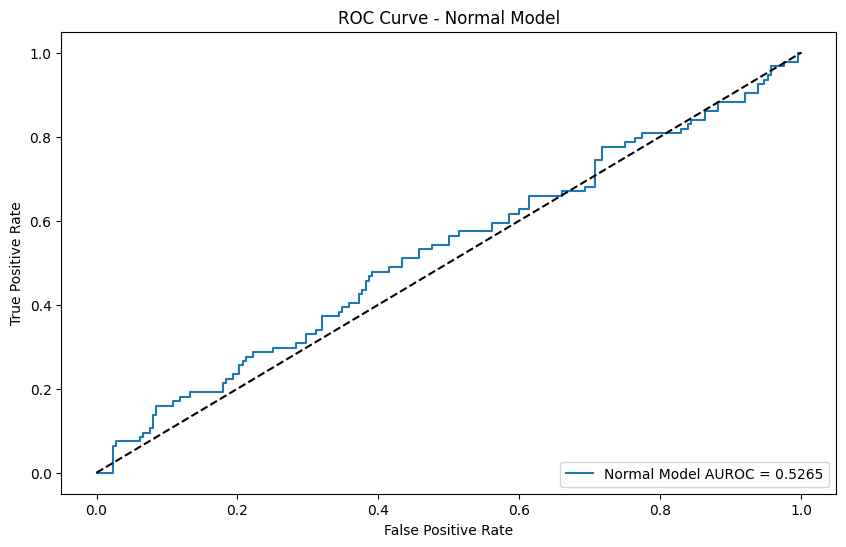


Hybrid Model Metrics:
Accuracy: 0.6961
F1 Score: 0.5747
Precision: 1.0000
Recall: 0.0106
AUROC: 0.5243376154154957

Normal Model Metrics:
Accuracy: 0.6830
F1 Score: 0.5735
Precision: 0.2857
Recall: 0.0213
AUROC: 0.5265455640305098 



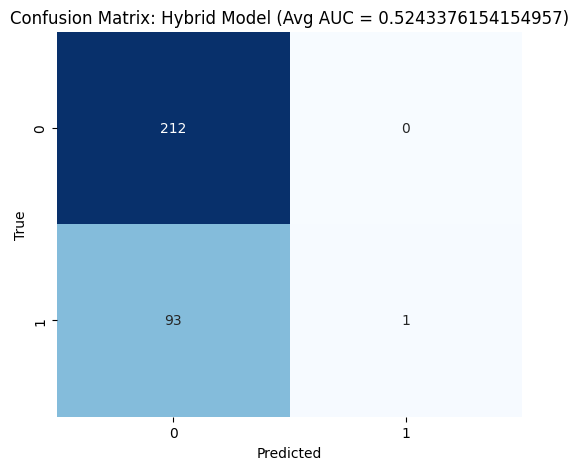

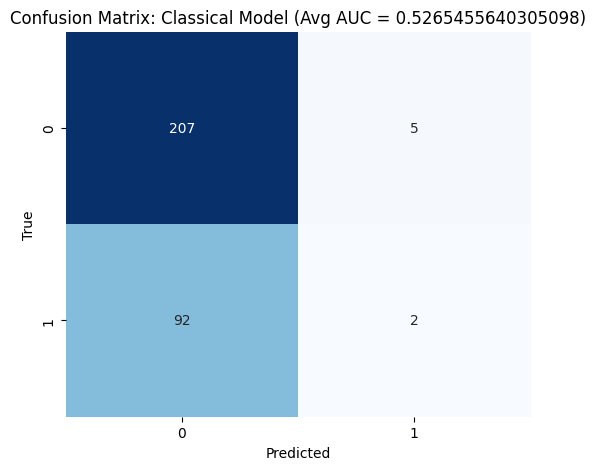

In [37]:
test(model_hybrid, model_normal, test_loader, num_classes=num_classes)

## Seed Experiment 3

In [38]:
seed = random.randint(1, 100)
print(f"Experiment with Seed {seed}:")
set_seed(seed)
train_loader, valid_loader, test_loader = load_data(batch_size=batch_size, dataset=dataset)
model = NormalModel(freeze=True, num_classes=2)
hybrid_model = QuantumHybridModel(q_depth=4, freeze=True, num_classes=2)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_name_hybrid = 'quantum_hybrid_model'
model_name_normal = 'normal_model'

Experiment with Seed 79:


In [39]:
model_normal, normal_train_losses, normal_train_accs, normal_val_losses, normal_val_accs, normal_train_aucs, normal_val_aucs = train_validate_model(
    n_epochs=n_epochs,
    model=model,
    model_name=model_name_normal,
    train_loader=train_loader,
    valid_loader=valid_loader,
    seed=seed
)

Epoch [1/100]
Training Loss: 0.6689, Training Accuracy: 60.77%, Training AUROC: 0.5070
Validation Loss: 0.6101, Validation Accuracy: 71.52%, Validation AUROC: 0.4603
Epoch [2/100]
Training Loss: 0.6381, Training Accuracy: 69.16%, Training AUROC: 0.5062
Validation Loss: 0.5926, Validation Accuracy: 72.73%, Validation AUROC: 0.4520
Epoch [3/100]
Training Loss: 0.6363, Training Accuracy: 69.71%, Training AUROC: 0.5187
Validation Loss: 0.6022, Validation Accuracy: 72.12%, Validation AUROC: 0.4603
Epoch [4/100]
Training Loss: 0.6260, Training Accuracy: 69.71%, Training AUROC: 0.5387
Validation Loss: 0.5892, Validation Accuracy: 73.94%, Validation AUROC: 0.4683
Epoch [5/100]
Training Loss: 0.6319, Training Accuracy: 68.98%, Training AUROC: 0.5102
Validation Loss: 0.5956, Validation Accuracy: 72.73%, Validation AUROC: 0.4729
Epoch [6/100]
Training Loss: 0.6158, Training Accuracy: 69.53%, Training AUROC: 0.5466
Validation Loss: 0.5830, Validation Accuracy: 73.94%, Validation AUROC: 0.4811
Epoc

In [40]:
model_hybrid, hybrid_train_losses, hybrid_train_accs, hybrid_val_losses, hybrid_val_accs, hybrid_train_aucs, hybrid_val_aucs = train_validate_model(
    n_epochs=n_epochs,
    model=hybrid_model,
    model_name=model_name_hybrid,
    train_loader=train_loader,
    valid_loader=valid_loader,
    seed=seed
)

Epoch [1/100]
Training Loss: 0.6412, Training Accuracy: 64.96%, Training AUROC: 0.5202
Validation Loss: 0.5821, Validation Accuracy: 76.36%, Validation AUROC: 0.5877
Epoch [2/100]
Training Loss: 0.6145, Training Accuracy: 70.26%, Training AUROC: 0.5161
Validation Loss: 0.5416, Validation Accuracy: 76.36%, Validation AUROC: 0.5745
Epoch [3/100]
Training Loss: 0.6171, Training Accuracy: 69.71%, Training AUROC: 0.5091
Validation Loss: 0.5544, Validation Accuracy: 76.97%, Validation AUROC: 0.5588
Epoch [4/100]
Training Loss: 0.6171, Training Accuracy: 70.07%, Training AUROC: 0.5032
Validation Loss: 0.5443, Validation Accuracy: 76.36%, Validation AUROC: 0.5602
Epoch [5/100]
Training Loss: 0.6162, Training Accuracy: 69.89%, Training AUROC: 0.4935
Validation Loss: 0.5502, Validation Accuracy: 76.36%, Validation AUROC: 0.5653
Epoch [6/100]
Training Loss: 0.6084, Training Accuracy: 70.26%, Training AUROC: 0.5404
Validation Loss: 0.5467, Validation Accuracy: 76.36%, Validation AUROC: 0.5993
Epoc

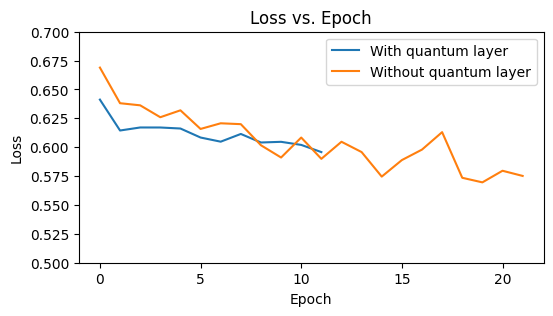

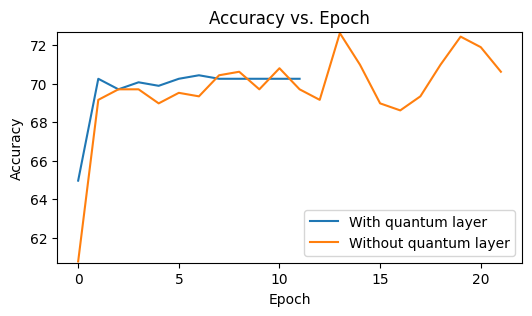

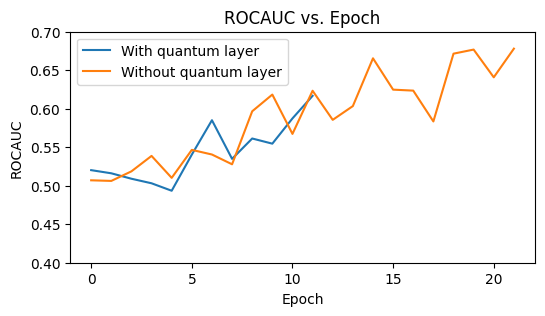

In [41]:
plot(hybrid_train_losses, normal_train_losses, hybrid_train_accs, normal_train_accs, hybrid_train_aucs, normal_train_aucs)

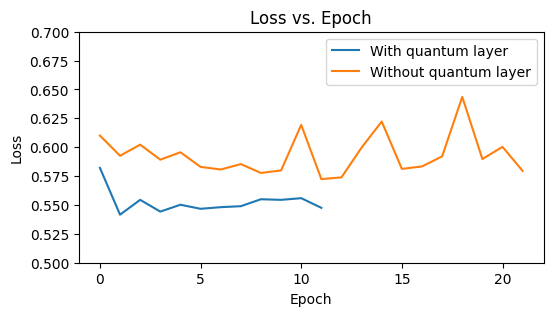

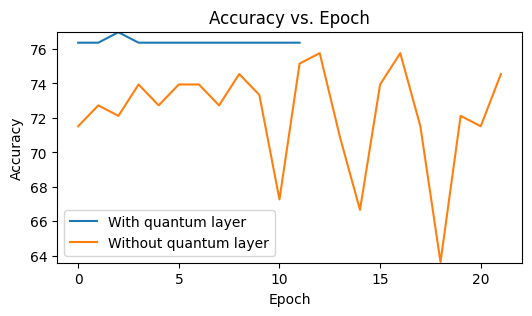

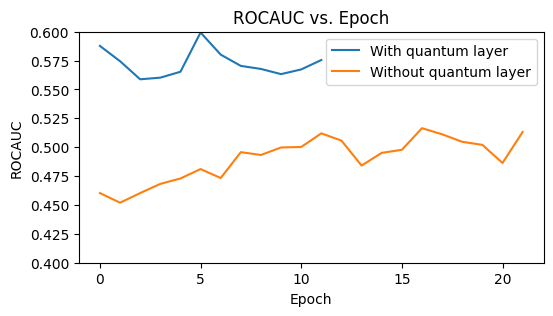

In [42]:
plot(hybrid_val_losses, normal_val_losses, hybrid_val_accs, normal_val_accs, hybrid_val_aucs, normal_val_aucs)

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


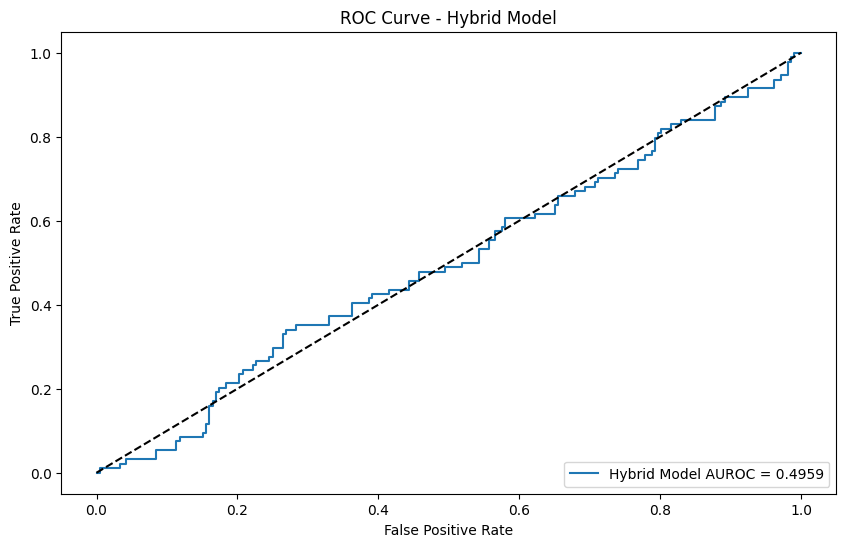

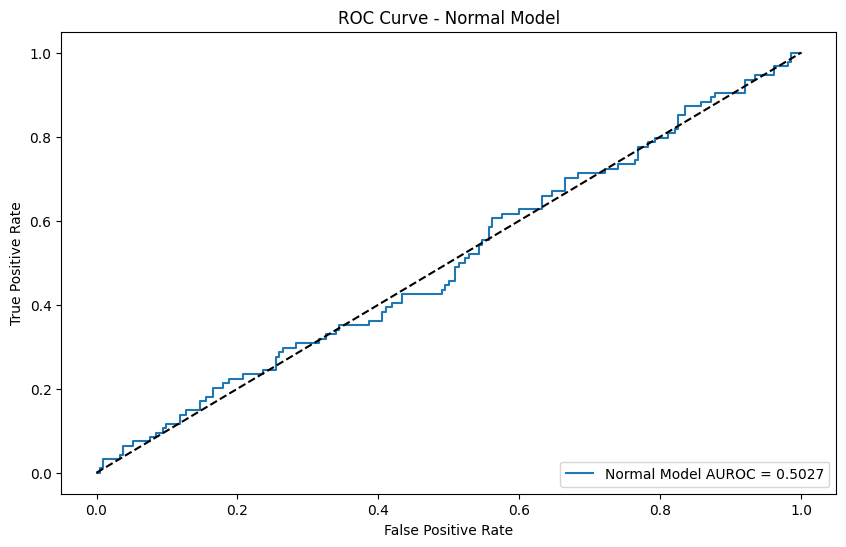


Hybrid Model Metrics:
Accuracy: 0.6928
F1 Score: 0.5671
Precision: 0.0000
Recall: 0.0000
AUROC: 0.49588518667201925

Normal Model Metrics:
Accuracy: 0.6961
F1 Score: 0.5858
Precision: 0.6000
Recall: 0.0319
AUROC: 0.5026595744680851 



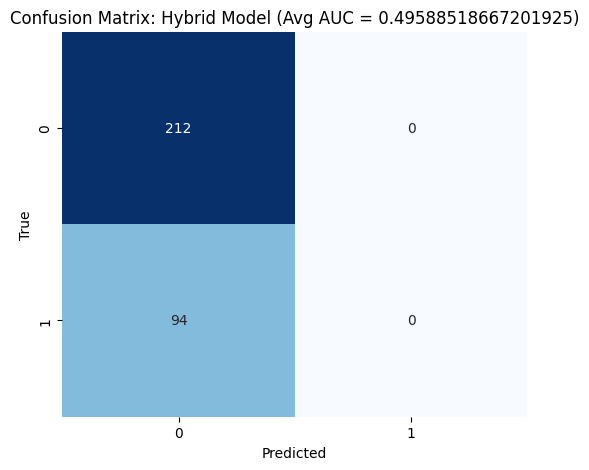

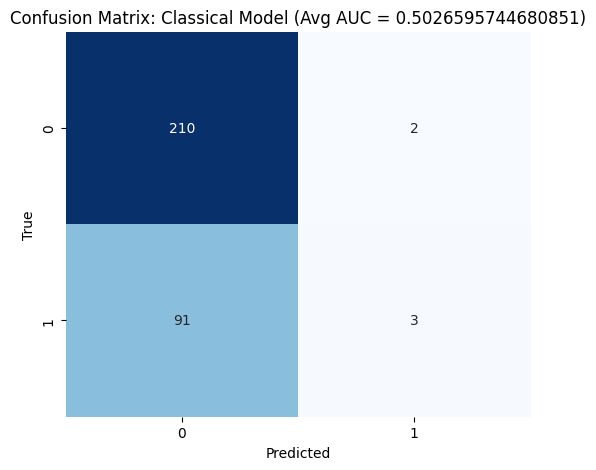

In [43]:
test(model_hybrid, model_normal, test_loader, num_classes=num_classes)

## Seed Experiment 4

In [44]:
seed = random.randint(1, 100)
print(f"Experiment with Seed {seed}:")
set_seed(seed)
train_loader, valid_loader, test_loader = load_data(batch_size=batch_size, dataset=dataset)
model = NormalModel(freeze=True, num_classes=2)
hybrid_model = QuantumHybridModel(q_depth=4, freeze=True, num_classes=2)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_name_hybrid = 'quantum_hybrid_model'
model_name_normal = 'normal_model'

Experiment with Seed 19:


In [45]:
model_normal, normal_train_losses, normal_train_accs, normal_val_losses, normal_val_accs, normal_train_aucs, normal_val_aucs = train_validate_model(
    n_epochs=n_epochs,
    model=model,
    model_name=model_name_normal,
    train_loader=train_loader,
    valid_loader=valid_loader,
    seed=seed
)

Epoch [1/100]
Training Loss: 0.6669, Training Accuracy: 61.50%, Training AUROC: 0.4739
Validation Loss: 0.6101, Validation Accuracy: 69.70%, Validation AUROC: 0.5077
Epoch [2/100]
Training Loss: 0.6296, Training Accuracy: 69.89%, Training AUROC: 0.5148
Validation Loss: 0.5657, Validation Accuracy: 77.58%, Validation AUROC: 0.4996
Epoch [3/100]
Training Loss: 0.6345, Training Accuracy: 70.26%, Training AUROC: 0.4884
Validation Loss: 0.5757, Validation Accuracy: 76.97%, Validation AUROC: 0.4988
Epoch [4/100]
Training Loss: 0.6376, Training Accuracy: 68.98%, Training AUROC: 0.4859
Validation Loss: 0.5788, Validation Accuracy: 76.36%, Validation AUROC: 0.4925
Epoch [5/100]
Training Loss: 0.6254, Training Accuracy: 68.43%, Training AUROC: 0.5134
Validation Loss: 0.5688, Validation Accuracy: 76.97%, Validation AUROC: 0.4847
Epoch [6/100]
Training Loss: 0.6321, Training Accuracy: 68.80%, Training AUROC: 0.4905
Validation Loss: 0.5627, Validation Accuracy: 76.97%, Validation AUROC: 0.4864
Epoc

In [46]:
model_hybrid, hybrid_train_losses, hybrid_train_accs, hybrid_val_losses, hybrid_val_accs, hybrid_train_aucs, hybrid_val_aucs = train_validate_model(
    n_epochs=n_epochs,
    model=hybrid_model,
    model_name=model_name_hybrid,
    train_loader=train_loader,
    valid_loader=valid_loader,
    seed=seed
)

Epoch [1/100]
Training Loss: 0.7712, Training Accuracy: 39.96%, Training AUROC: 0.4939
Validation Loss: 0.6422, Validation Accuracy: 68.48%, Validation AUROC: 0.5842
Epoch [2/100]
Training Loss: 0.6453, Training Accuracy: 65.88%, Training AUROC: 0.4925
Validation Loss: 0.5643, Validation Accuracy: 76.36%, Validation AUROC: 0.5861
Epoch [3/100]
Training Loss: 0.6134, Training Accuracy: 70.26%, Training AUROC: 0.4753
Validation Loss: 0.5506, Validation Accuracy: 76.36%, Validation AUROC: 0.6009
Epoch [4/100]
Training Loss: 0.6117, Training Accuracy: 70.26%, Training AUROC: 0.4586
Validation Loss: 0.5498, Validation Accuracy: 76.36%, Validation AUROC: 0.6011
Epoch [5/100]
Training Loss: 0.6112, Training Accuracy: 70.26%, Training AUROC: 0.4621
Validation Loss: 0.5499, Validation Accuracy: 76.36%, Validation AUROC: 0.6077
Epoch [6/100]
Training Loss: 0.6085, Training Accuracy: 70.26%, Training AUROC: 0.4953
Validation Loss: 0.5507, Validation Accuracy: 76.36%, Validation AUROC: 0.6032
Epoc

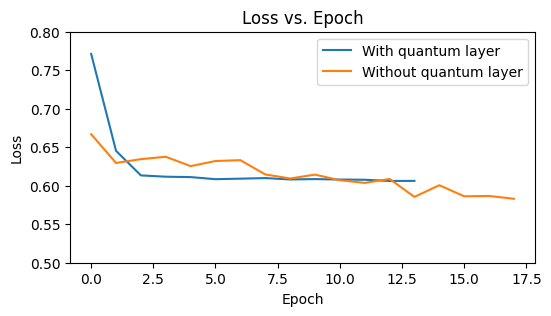

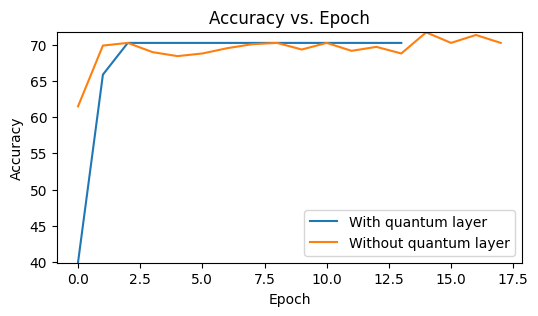

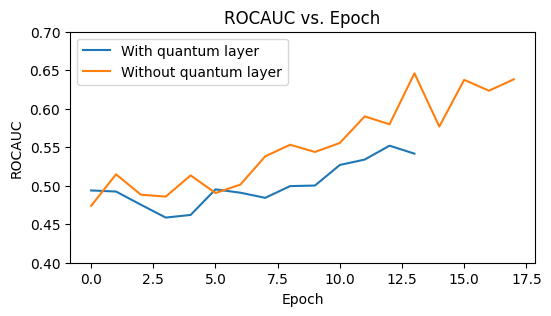

In [47]:
plot(hybrid_train_losses, normal_train_losses, hybrid_train_accs, normal_train_accs, hybrid_train_aucs, normal_train_aucs)

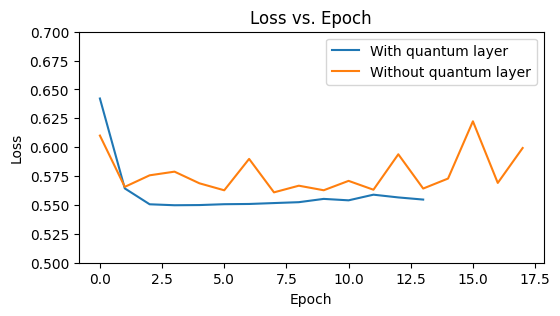

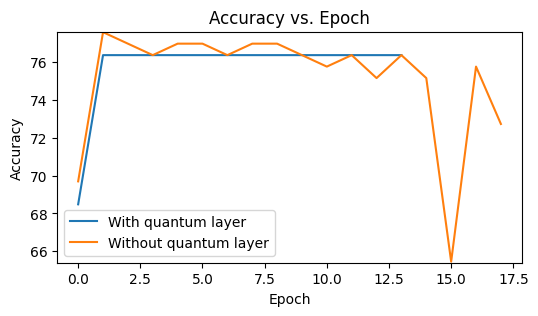

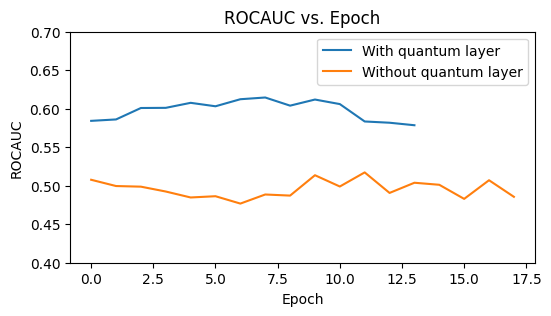

In [48]:
plot(hybrid_val_losses, normal_val_losses, hybrid_val_accs, normal_val_accs, hybrid_val_aucs, normal_val_aucs)

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


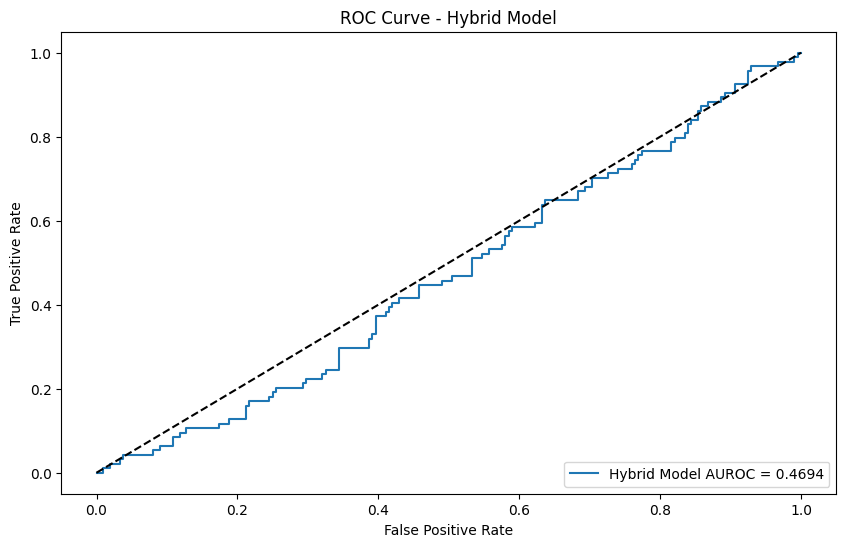

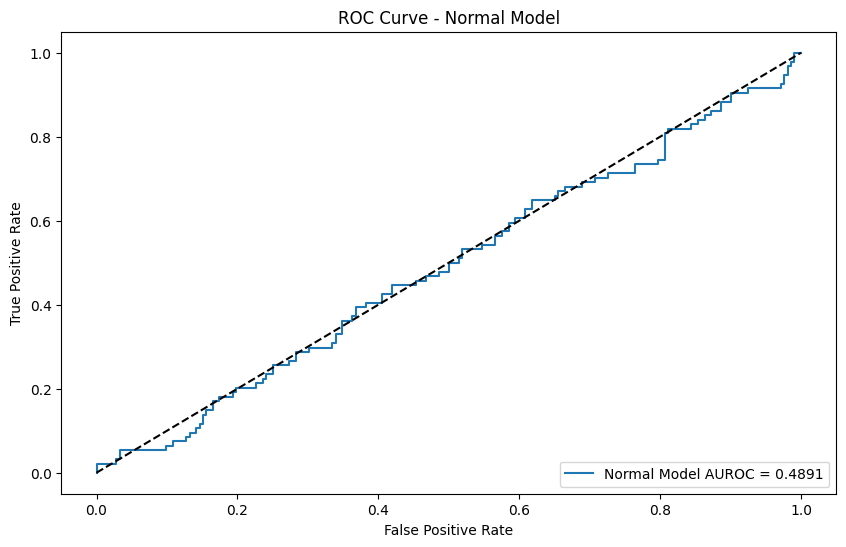


Hybrid Model Metrics:
Accuracy: 0.6928
F1 Score: 0.5671
Precision: 0.0000
Recall: 0.0000
AUROC: 0.46943998394219183

Normal Model Metrics:
Accuracy: 0.6601
F1 Score: 0.5751
Precision: 0.2500
Recall: 0.0532
AUROC: 0.4890606182256122 



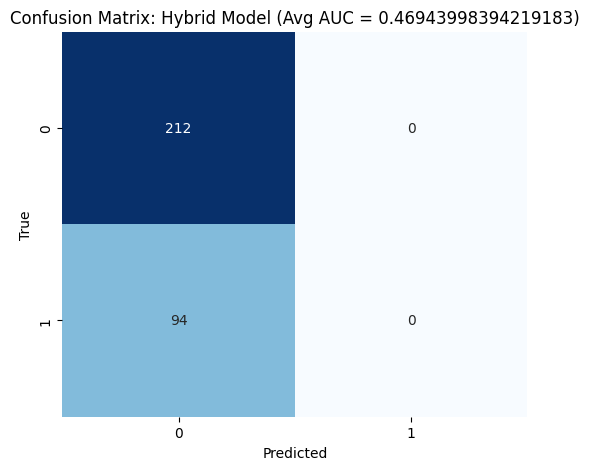

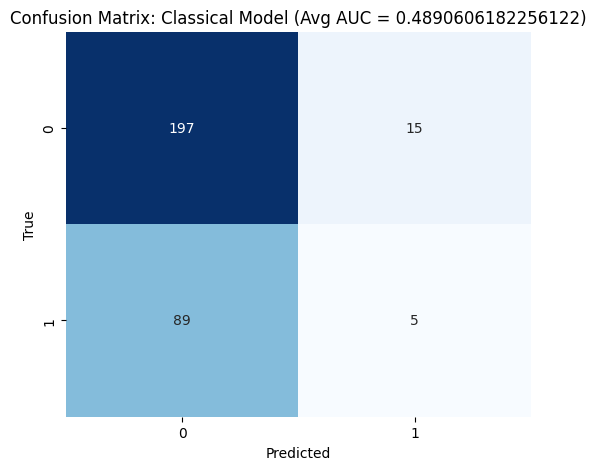

In [49]:
test(model_hybrid, model_normal, test_loader, num_classes=num_classes)

## Seed Experiment 5

In [24]:
seed = random.randint(1, 100)
print(f"Experiment with Seed {seed}:")
set_seed(seed)
train_loader, valid_loader, test_loader = load_data(batch_size=batch_size, dataset=dataset)
model_normal = NormalModel(freeze=True, num_classes=2)
model_hybrid = QuantumHybridModel(q_depth=4, freeze=True, num_classes=2)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_name_hybrid = 'quantum_hybrid_model'
model_name_normal = 'normal_model'

Experiment with Seed 42:


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 194MB/s]


In [57]:
model_normal, normal_train_losses, normal_train_accs, normal_val_losses, normal_val_accs, normal_train_aucs, normal_val_aucs = train_validate_model(
    n_epochs=n_epochs,
    model=model,
    model_name=model_name_normal,
    train_loader=train_loader,
    valid_loader=valid_loader,
    seed=seed
)

Epoch [1/100]
Training Loss: 0.5546, Training Accuracy: 71.72%, Training AUROC: 0.7200
Validation Loss: 0.5999, Validation Accuracy: 71.52%, Validation AUROC: 0.4902
Epoch [2/100]
Training Loss: 0.5462, Training Accuracy: 72.26%, Training AUROC: 0.7341
Validation Loss: 0.6116, Validation Accuracy: 70.30%, Validation AUROC: 0.4866
Epoch [3/100]
Training Loss: 0.5470, Training Accuracy: 71.53%, Training AUROC: 0.7432
Validation Loss: 0.5990, Validation Accuracy: 70.91%, Validation AUROC: 0.4847
Epoch [4/100]
Training Loss: 0.5547, Training Accuracy: 71.72%, Training AUROC: 0.7113
Validation Loss: 0.6183, Validation Accuracy: 67.88%, Validation AUROC: 0.4801
Epoch [5/100]
Training Loss: 0.5420, Training Accuracy: 72.63%, Training AUROC: 0.7489
Validation Loss: 0.5963, Validation Accuracy: 73.33%, Validation AUROC: 0.4780
Epoch [6/100]
Training Loss: 0.5592, Training Accuracy: 71.72%, Training AUROC: 0.7048
Validation Loss: 0.5931, Validation Accuracy: 73.94%, Validation AUROC: 0.4809
Epoc

In [58]:
model_hybrid, hybrid_train_losses, hybrid_train_accs, hybrid_val_losses, hybrid_val_accs, hybrid_train_aucs, hybrid_val_aucs = train_validate_model(
    n_epochs=n_epochs,
    model=hybrid_model,
    model_name=model_name_hybrid,
    train_loader=train_loader,
    valid_loader=valid_loader,
    seed=seed
)

Epoch [1/100]
Training Loss: 0.5739, Training Accuracy: 72.63%, Training AUROC: 0.6887
Validation Loss: 0.5747, Validation Accuracy: 73.94%, Validation AUROC: 0.5279
Epoch [2/100]
Training Loss: 0.5626, Training Accuracy: 72.45%, Training AUROC: 0.7256
Validation Loss: 0.5822, Validation Accuracy: 71.52%, Validation AUROC: 0.5372
Epoch [3/100]
Training Loss: 0.5699, Training Accuracy: 72.26%, Training AUROC: 0.6957
Validation Loss: 0.5759, Validation Accuracy: 73.94%, Validation AUROC: 0.5210
Epoch [4/100]
Training Loss: 0.5677, Training Accuracy: 71.53%, Training AUROC: 0.7130
Validation Loss: 0.5783, Validation Accuracy: 74.55%, Validation AUROC: 0.5263
Epoch [5/100]
Training Loss: 0.5658, Training Accuracy: 72.08%, Training AUROC: 0.7185
Validation Loss: 0.5865, Validation Accuracy: 72.12%, Validation AUROC: 0.5228
Epoch [6/100]
Training Loss: 0.5681, Training Accuracy: 72.26%, Training AUROC: 0.7106
Validation Loss: 0.5662, Validation Accuracy: 76.36%, Validation AUROC: 0.5108
Epoc

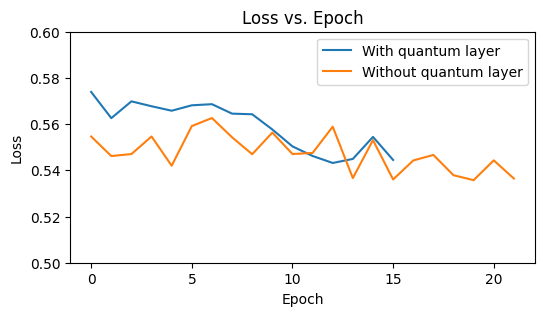

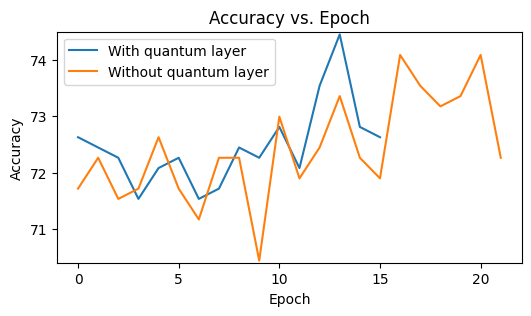

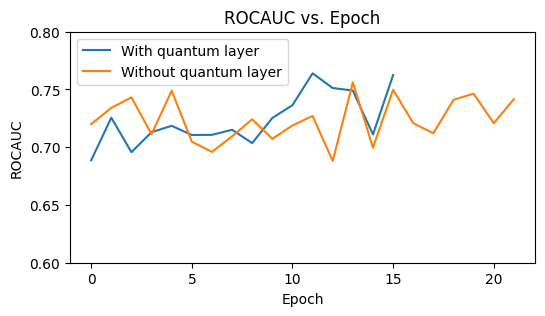

In [59]:
plot(hybrid_train_losses, normal_train_losses, hybrid_train_accs, normal_train_accs, hybrid_train_aucs, normal_train_aucs)

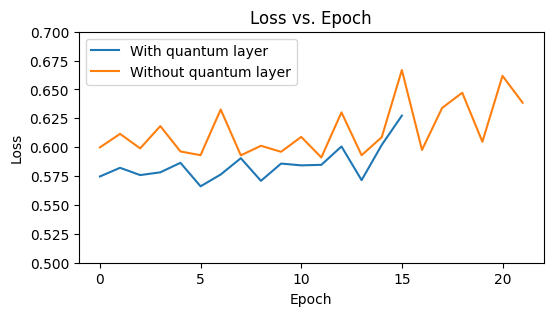

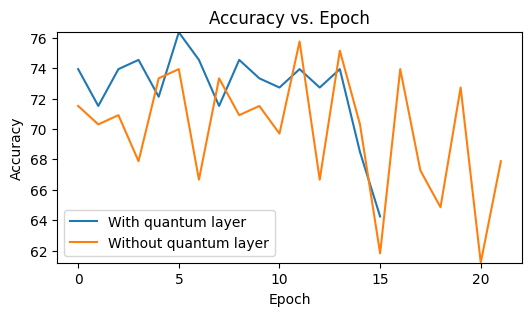

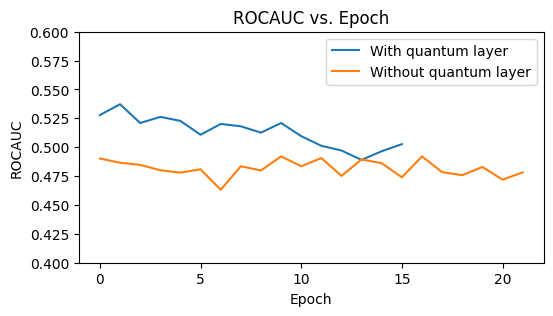

In [60]:
plot(hybrid_val_losses, normal_val_losses, hybrid_val_accs, normal_val_accs, hybrid_val_aucs, normal_val_aucs)

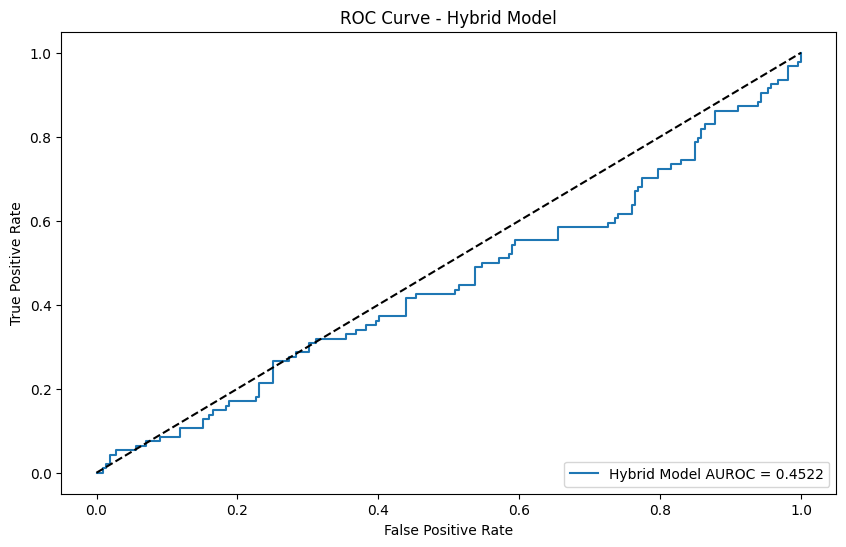

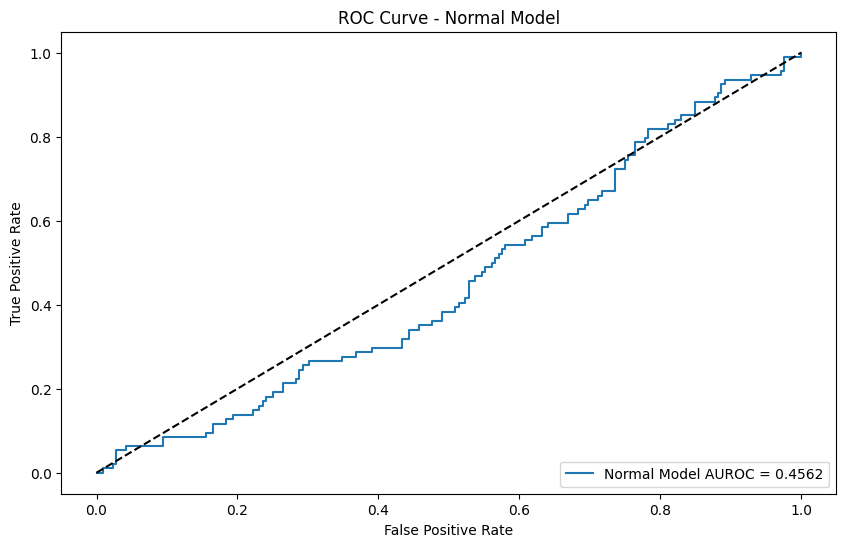


Hybrid Model Metrics:
Accuracy: 0.3203
F1 Score: 0.2278
Precision: 0.2950
Recall: 0.8723
AUROC: 0.4521778402248093

Normal Model Metrics:
Accuracy: 0.4085
F1 Score: 0.4134
Precision: 0.2878
Recall: 0.6277
AUROC: 0.4562424729024488 



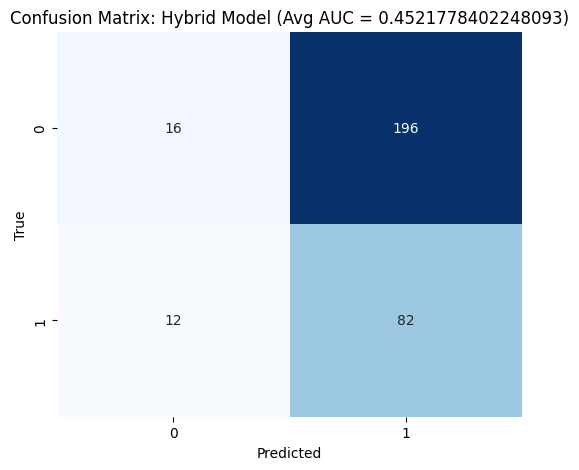

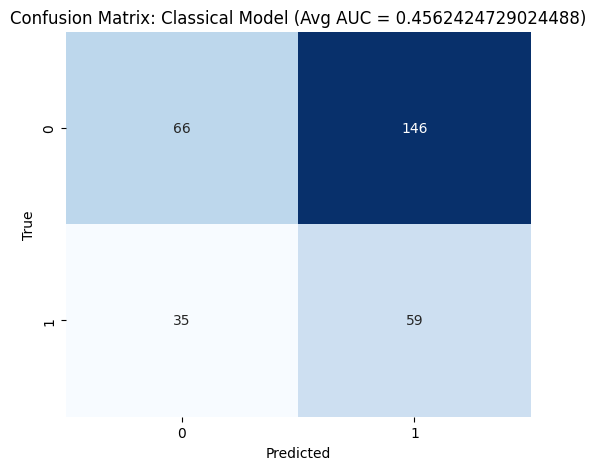

In [25]:
test(model_hybrid, model_normal, test_loader, num_classes=num_classes)